<a href="https://colab.research.google.com/github/MScaramuzzi/A1-RNNs-for-Sequence-Labeling/blob/main/Assignment_1_Semi-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

**Due to**: 11/01/2022 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

1. Commenta codice getting dei files
    1. Cambia struttura cartelle


Importing and installing useful libraries

In [4]:
!pip3 install keras_tuner
!pip install keras-tuner tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


In [5]:
import urllib.request  #  download files
import tarfile  #  unzip files
import shutil
import os
import urllib.request  #  download files
import zipfile  #  unzip files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random

from tensorflow import keras
import tensorflow as tf
#from tensorflow.keras import layers
import keras_tuner as kt
from keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import L2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dropout, LSTM, Bidirectional, GRU, Dense, TimeDistributed, Activation,Masking
from keras_tuner import RandomSearch, Objective
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


### Ensuring reproducibility

In [6]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [7]:
set_reproducibility(42)

## 1. Download the corpora and split it in training and test sets, structuring a dataframe.




**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Splitting**: you can decide to split documents into sentences or not, the choice is yours.


**I/O structure**: The input data will have three dimensions: 1-documents/sentences, 2-token, 3-features; for the output there are 2 possibilities: if you use one-hot encoding it will be 1-documents/sentences, 2-token labels, 3-classes, if you use a single integer that indicates the number of the class it will be 1-documents/sentences, 2-token labels.

#### Dataset downloading

In [8]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")

with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("Dataset")

print("Successful extraction")

Successful download
Successful extraction


In [9]:
data_folder=os.getcwd()+"/Dataset/dependency_treebank/"

In [10]:
# Just needed in case you'd like to append it to an array
data = []

for filename in os.listdir(data_folder):
    if filename.endswith("dp"): 
        data.append(filename)

In [11]:
# SB MODIFIED CODE - START

"""
In this code block we define variables for extracting the tags for each sentence
In the for loop below we also exploit the fact we are already looping to count 
tags and words, this will be needed for the encoding of the vocabulary later.
"""

sentences = []
words = []
unique_tags_train = []
unique_tags_test = []
unique_tags_val = []
tags = []
tag2 = []
file_len = []
file_len_sent = []
file_len_tags = []

cnt_words_train = 0
cnt_words_val = 0
cnt_words_test = 0
cnt_words_sent = 0
cnt_tags_sent = 0
cnt_sents = 0
cnt_sents_train = 0
cnt_sents_val = 0
cnt_sents_test = 0

docs = sorted(os.listdir(data_folder))

for filename in docs:
    if filename.endswith(".dp"): 
        with open(os.path.join(data_folder, filename), mode='r', encoding='utf-8') as text:
                for i,line in enumerate(text):
                    if len(line.split())>0:
                        word, tag, _ = line.split("\t")  # structure of line in file word, tag, number to ignore
                        words.append(word)
                        tags.append(tag)
                        cnt_words_sent += 1                        
                        cnt_tags_sent += 1

                        # Get train sentences/tags
                        if (filename.startswith("wsj_00") or filename == "wsj_0100.dp"):
                            cnt_words_train +=1
                            if (tag not in unique_tags_train): 
                                unique_tags_train.append(tag)
                            if word == ".": # end of sentence condition
                                sentences.append(words[:i])
                                cnt_sents += 1
                                cnt_sents_train+=1
                                tag2.append(tags[:i])
                                words = []
                                tags =[]
                                file_len_tags.append(cnt_tags_sent)
                                file_len_sent.append(cnt_words_sent)
                                cnt_words_sent = 0
                                cnt_tags_sent = 0

                        # Get val sentences/tags
                        elif (not filename == "wsj_0100.dp") and (filename.startswith("wsj_010") or filename.startswith("wsj_011") or filename.startswith("wsj_012") or filename.startswith("wsj_013") or filename.startswith("wsj_014") or filename.startswith("wsj_0150")):
                            cnt_words_val +=1
                            if (tag not in unique_tags_val):
                                unique_tags_val.append(tag)
                            if word == ".": 
                                sentences.append(words[:i])
                                cnt_sents += 1
                                cnt_sents_val+=1
                                tag2.append(tags[:i])
                                words = []
                                tags =[]
                                file_len_tags.append(cnt_tags_sent)
                                file_len_sent.append(cnt_words_sent)
                                cnt_words_sent = 0
                                cnt_tags_sent = 0
                                
                        # Get test sentences/tags
                        elif (not filename == "wsj_0150.dp") and (filename.startswith("wsj_015") or filename.startswith("wsj_016") or filename.startswith("wsj_017") or filename.startswith("wsj_018") or filename.startswith("wsj_019")):
                            cnt_words_test +=1
                            if (tag not in unique_tags_test):
                                unique_tags_test.append(tag)
                            if word == ".": # condizione fine frase
                                sentences.append(words[:i])
                                cnt_sents += 1
                                cnt_sents_test+=1
                                tag2.append(tags[:i])
                                words = []
                                tags =[]
                                file_len_tags.append(cnt_tags_sent)
                                file_len_sent.append(cnt_words_sent)
                                cnt_words_sent = 0
                                cnt_tags_sent = 0

                file_len.append(cnt_sents)
        cnt_sents = 0


In [12]:
print(f"train: {sorted(unique_tags_train)} \n")
print(f"validation: {sorted(unique_tags_val)} \n")
print(f"test: {sorted(unique_tags_test)}")

train: ['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'] 

validation: ['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'] 

test: ['$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


#### Understanding content of tag arrays

In [13]:
print(f"Unique tags in train set: {len(unique_tags_train)} tags \n")
print(f"Unique tags in validation set: {len(unique_tags_val)} tags \n")
print(f"Unique tags in test set: {len(unique_tags_test)} tags")

Unique tags in train set: 45 tags 

Unique tags in validation set: 44 tags 

Unique tags in test set: 40 tags


In [14]:
print("- Tags that are present in the train set and are not present in the validation set:",list(set(unique_tags_train).difference(set(unique_tags_val))))
print()
print("- Tags that are present in the train set and are not present in the test set:",list(set(unique_tags_train).difference(set(unique_tags_test))))
print()
print("- Tags that are present in the validation set and are not present in the test set:",list(set(unique_tags_val).difference(set(unique_tags_test))))

- Tags that are present in the train set and are not present in the validation set: ['SYM']

- Tags that are present in the train set and are not present in the test set: ['SYM', 'FW', 'UH', 'LS', '#']

- Tags that are present in the validation set and are not present in the test set: ['UH', '#', 'LS', 'FW']


### Retrieving punctuation indices 

This will be useful later for error analysis

In [15]:
sort_tags = np.array(sorted(unique_tags_train))

In [16]:
print(sort_tags)

['#' '$' "''" ',' '-LRB-' '-RRB-' '.' ':' 'CC' 'CD' 'DT' 'EX' 'FW' 'IN'
 'JJ' 'JJR' 'JJS' 'LS' 'MD' 'NN' 'NNP' 'NNPS' 'NNS' 'PDT' 'POS' 'PRP'
 'PRP$' 'RB' 'RBR' 'RBS' 'RP' 'SYM' 'TO' 'UH' 'VB' 'VBD' 'VBG' 'VBN' 'VBP'
 'VBZ' 'WDT' 'WP' 'WP$' 'WRB' '``']


We need to the remove the indices associated with the following symbols:

* Punctuation:
  - -LRB- &rarr; "Left Round Bracket" &rarr; "("
  - -RRB- &rarr; "Right Round Bracket" &rarr; "("
  - # 
  - $
  - ' ' 
  - , 
  - . 
  - : 


* Symbols:

  - LS &rarr; List item marker
  - SYM &rarr; Symbol
  - ``

In [17]:
indices = [0, 1, 2, 3, 4, 5, 6,7, 17, 31, 44] # symbols and punctuation
print("Displaying the tags and their associated index: \n")
print(dict(zip(sort_tags[indices],indices)))

Displaying the tags and their associated index: 

{'#': 0, '$': 1, "''": 2, ',': 3, '-LRB-': 4, '-RRB-': 5, '.': 6, ':': 7, 'LS': 17, 'SYM': 31, '``': 44}


In [18]:
# Counting the sentences of the sets
print(f"- Sentences in the train set: {cnt_sents_train} sentences")
print(f"- Sentences in the validation set: {cnt_sents_val} sentences")
print(f"- Sentences in the test set: {cnt_sents_test} sentences")

- Sentences in the train set: 1936 sentences
- Sentences in the validation set: 1256 sentences
- Sentences in the test set: 636 sentences


### Dataframe creation

In [19]:
# Creating the structure of the dataframe rows
dataframe_rows = {
    'sentences': sentences,
    'tags': tag2,
    #repeat the document name for each sentence in the document 
    "docs": np.repeat(docs, file_len),  
}

In [20]:
df = pd.DataFrame(dataframe_rows)
df.head(10)

,sentences,tags,docs
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",wsj_0001.dp
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",wsj_0001.dp
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",wsj_0002.dp
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",wsj_0003.dp
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",wsj_0003.dp
5,"[Lorillard, Inc., ,, the, unit, of, New, York-...","[NNP, NNP, ,, DT, NN, IN, JJ, JJ, NNP, NNP, WD...",wsj_0003.dp
6,"[Although, preliminary, findings, were, report...","[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, IN, ,...",wsj_0003.dp
7,"[A, Lorillard, spokewoman, said, ,, ``, This, ...","[DT, NNP, NN, VBD, ,, ``, DT, VBZ, DT, JJ, NN, .]",wsj_0003.dp
8,"[We, 're, talking, about, years, ago, before, ...","[PRP, VBP, VBG, IN, NNS, IN, IN, NN, VBD, IN, ...",wsj_0003.dp
9,"[There, is, no, asbestos, in, our, products, n...","[EX, VBZ, DT, NN, IN, PRP$, NNS, RB, .]",wsj_0003.dp


In [21]:
print("Displaying the number of sentences of first five documents: ")
file_len[:5] 

Displaying the number of sentences of first five documents: 


[2, 1, 30, 17, 3]

Splits: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

In order to achieve the above mentioned split we are retrieving the index for the last document in each the set:

- The train sets ends where we find last sentence of the document ```"wsj_100.dp"```
- The validation sets ends where we find last sentence of the document ```"wsj_150.dp"```. From this we subtract the already counted rows of the train set
- The test sets spans from the lenght whole lenght of the document minus the already counted rows. 

In [22]:
train_idx=df.query("docs == 'wsj_0101.dp'").index[0] - 1
val_idx=df.query("docs == 'wsj_0151.dp'").index[0] - train_idx - 1
test_idx= len(df) - val_idx - train_idx

Create 3 arrays for assigning the correct value to each row, concatenating them with ```hstack``` then ```raveling``` in order to have an unique array to assing as a column. 

In [23]:
split_tr = np.repeat("train",train_idx)
split_val = np.repeat("val",val_idx)
split_test = np.repeat("test",test_idx)
splits = np.hstack((split_tr,split_val,split_test)).ravel() 

In [24]:
df = df.assign(split=splits) # create the split column

### Dataframe visualization

In [25]:
print(f'Dataset shape: {df.shape} \n')

print(f'Dataset columns: {df.columns.values} \n')

print(f'Dataset Info: \n {df.info} \n')

print('Dataset Head: ')

display(df.head())

print('\n Dataset Description: \n ')

display(df.describe())

Dataset shape: (3828, 4) 

Dataset columns: ['sentences' 'tags' 'docs' 'split'] 

Dataset Info: 
 <bound method DataFrame.info of                                               sentences  \
0     [Pierre, Vinken, ,, 61, years, old, ,, will, j...   
1     [Mr., Vinken, is, chairman, of, Elsevier, N.V....   
2     [Rudolph, Agnew, ,, 55, years, old, and, forme...   
3     [A, form, of, asbestos, once, used, to, make, ...   
4     [The, asbestos, fiber, ,, crocidolite, ,, is, ...   
...                                                 ...   
3823  [They, also, said, that, more, than, a, dozen,...   
3824  [Sen., Kennedy, said, in, a, separate, stateme...   
3825  [Trinity, Industries, Inc., said, it, reached,...   
3826                   [Terms, were, n't, disclosed, .]   
3827  [Trinity, said, it, plans, to, begin, delivery...   

                                                   tags         docs  split  
0     [NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...  wsj_0001.dp  train  
1    

,sentences,tags,docs,split
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",wsj_0001.dp,train
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",wsj_0001.dp,train
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",wsj_0002.dp,train
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",wsj_0003.dp,train
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",wsj_0003.dp,train



 Dataset Description: 
 


,sentences,tags,docs,split
count,3828,3828,3828,3828
unique,3819,3795,199,3
top,"[Terms, were, n't, disclosed, .]","[NNS, VBD, RB, VBN, .]",wsj_0118.dp,train
freq,8,8,172,1935



Distribution of tags in the splits:


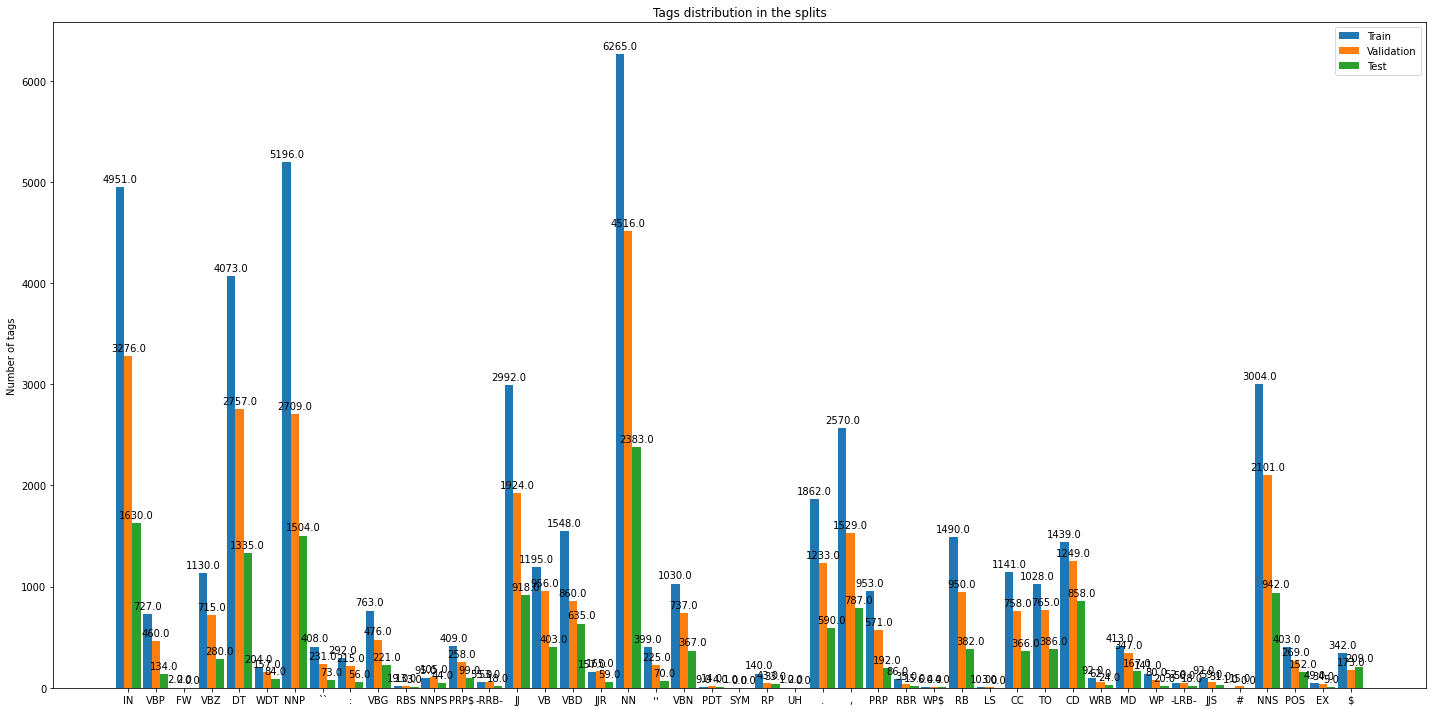

In [26]:
print('\nDistribution of tags in the splits:')

tags_labels_idx = {tag:idx for idx,tag in enumerate(set([elem for seq in df['tags'] for elem in seq]))}

tags_bars_train = np.zeros(len(tags_labels_idx))
tags_bars_val = np.zeros(len(tags_labels_idx))
tags_bars_test = np.zeros(len(tags_labels_idx))


for idx, row in df.loc[df['split'] == 'train'].iterrows():
    for tag in row['tags']:
        tags_bars_train[tags_labels_idx[tag]] += 1
for idx, row in df.loc[df['split'] == 'val'].iterrows():
    for tag in row['tags']:
        tags_bars_val[tags_labels_idx[tag]] += 1
for idx, row in df.loc[df['split'] == 'test'].iterrows():
    for tag in row['tags']:
        tags_bars_test[tags_labels_idx[tag]] += 1

tags_labels = list(tags_labels_idx.keys())

x = np.arange(len(tags_labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
train_rects = ax.bar(x - width, tags_bars_train, width, label='Train')
valid_rects = ax.bar(x, tags_bars_val, width, label='Validation')
test_rects = ax.bar(x + width, tags_bars_test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of tags')
ax.set_title('Tags distribution in the splits')
ax.set_xticks(x)
ax.set_xticklabels(tags_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(train_rects)
autolabel(valid_rects)
autolabel(test_rects)

fig.tight_layout()

plt.show()

## Togli torchtex

In [27]:
# SB - START NEW CODE SECTION

import torchtext

# Dowload GloVe Vocabulary 6B (It includes sources as Gigaword ( newswire ) consistent with the domain of the Input data (WSJ articles))
V1 = torchtext.vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                           
100%|█████████▉| 399999/400000 [00:14<00:00, 28476.96it/s]


## Aggiungi ignore punctiation

In [ ]:
seeds = [42,104,666,1337,2022]
avg_metric_info = {}

for seed in seeds:
    print(f'Running with seed: {seed}')
    set_reproducibility(seed)

## Dataset encoding

In [28]:
# arrays dimensions initialization 
embedding_dim = 100 # set accordingly to the embedding chosen (GloVe 6B 100d)
missing_pos_tag = 1 # assuming to add a single one hot encoding for any POS tag not present in training

# dimensions initialization 
tot_sentence_num = len(df['sentences']) # Total number of sentences
tot_sentence_train = cnt_words_train # Total number of training sentences
tot_sentence_val = cnt_words_val # Total number of validation sentences
tot_sentence_test = cnt_words_test # Total number of test sentences

tot_token_num = max(file_len_tags) # Total number of tokens
max_sentence_len = max(file_len_sent) # Max sentence length (number of tokens)

###  One Hot Encoding of POS Tags


The task to the performed by the model is a multi-class classification therefore the labels are not encoded assigning integer values to each different class, but rather by one hot encoding.

In [29]:
ohe_df = pd.get_dummies(unique_tags_train) # Get one hot encoding for POS tags in the training dataset
ohe_df['UNK'] = 0  # Add a column for 'UNK' POS tags
ohe = ohe_df.to_numpy(dtype=float) 
unk_axis=np.ones((1,len(unique_tags_train)+1)) # Add the encoding for UNK POS tag
ohe = np.concatenate((ohe,unk_axis)) 

# Numpy arrays X (token embddings) and Y (One Hot Encoding of POS tag classes) initialization:
# X shape: dim 0 (total sentences per dataset), dim 1 (max tokens), dim 2 (features (embedding vectors))
X_train = np.zeros((cnt_sents_train,max_sentence_len,embedding_dim))
X_val = np.zeros((cnt_sents_val,max_sentence_len,embedding_dim))
X_test = np.zeros((cnt_sents_test,max_sentence_len,embedding_dim))

# Y shape: dim 0 (total sentences per dataset), dim 1 (max tokens), dim 2 (One Hot Encoding vectors)) 
Y_train = np.zeros((cnt_sents_train,max_sentence_len,ohe.shape[1]))
Y_val = np.zeros((cnt_sents_val,max_sentence_len,ohe.shape[1]))
Y_test = np.zeros((cnt_sents_test,max_sentence_len,ohe.shape[1]))

Vocabularies for managing OOV words

In [30]:
# Out of Vocabulary initialization
OOV1 = {}
OOV2 = {}
OOV3 = {}

In [34]:
# X and Y arrays update retriving token/tag pairs from df dataframe and retriving embedding and one hot encoding vectors
for index,row in df.iterrows(): # Iterate over the sentences in df dataframe and update X with the token embedding vector and Y with the class one hot encoding

    # Training
    # The model will be trained on X_train and Y_train containing V1 and OOV1 embeddings (V2) and one hot encodings found in training
    if ((row['docs'].startswith("wsj_00")) or (row['docs'] == "wsj_0100.dp")):
      for i in range(0,len(row['sentences'])): # Iterate over the words of the fetched sentence 

        # Embedding from V1 (GloVe Voc.6B), if not found generate a new random embedding and add it to OOV1. V1+OOV1 = V2
        embedding_vector = V1.get_vecs_by_tokens(row['sentences'][i]) # Fetch pretrained embedding vector from GloVe
        a = np.count_nonzero(embedding_vector)
        if a != 0: # Embedding found 
          X_train[index,i,:] = embedding_vector
        elif row['sentences'][i] in OOV1.keys(): # No embedding found in Vocabulary but embedding already generated as OOV token
          X_train[index,i,:] = OOV1[row['sentences'][i]]
        else: # No embedding found neither in Vocabulary nor in OOV1: generate a new embedding and update OOV
          X_train[index,i,:] = np.random.rand((embedding_dim)) # Embedding with random vector
          #X_train[index,i,:] = np.ones((embedding_dim)) # Embedding for fixed UNK placeholder
          OOV1[row['sentences'][i]] = X_train[index,i,:]
        # One Hot Encoding vector fetch and Y_train update
        if (row['tags'][i]) in unique_tags_train:
          ohe_idx = unique_tags_train.index(row['tags'][i]) 
          Y_train[index,i,:] = ohe[ohe_idx]
        else: # No One Hot Encoding vector found
          Y_train[index,i,:] = np.zeros((ohe.shape[1])) # One Hot Encoding for fixed UNK placeholder.
    
    # Validation
    # The model will be validated on X_val and Y_val containing V1+OOV1+OOV2 embeddings (V3) and POS tag one hot encodings found in training (plus placeholder if not found)
    elif ((row['docs'] != "wsj_0100.dp") and (row['docs'].startswith("wsj_010") or row['docs'].startswith("wsj_011") or row['docs'].startswith("wsj_012") or row['docs'].startswith("wsj_013") or row['docs'].startswith("wsj_014") or row['docs'].startswith("wsj_0150"))): 

      if (row['docs'] == "wsj_0101.dp"): # First sentence of validation set 
        OOV2 = OOV1 # initialize OVV2 with embeddings already generate in OOV1
        idx_t = index # offset to start array index from 0
      idx = index - idx_t

      for i in range(0,len(row['sentences'])): # Iterate over the words of the fetched sentence 

        # Embedding from V1+OVV1 (V2), if not found generate a new random embedding and add it to OOV2. V1+OOV1+OOV2 = V3
        embedding_vector = V1.get_vecs_by_tokens(row['sentences'][i]) # Fetch pretrained embedding vector from GloVe
        a = np.count_nonzero(embedding_vector)
        if a != 0: # Embedding found 
          X_val[idx,i,:] = embedding_vector
        elif row['sentences'][i] in OOV2.keys(): # No embedding found in Vocabulary but embedding already generated as OOV2 token
          X_val[idx,i,:] = OOV2[row['sentences'][i]]
        else: # No embedding found neither in Vocabulary nor in OOV1: generate a new embedding and update OOV
          X_val[idx,i,:] = np.random.rand((embedding_dim)) # Embedding with random vector
          OOV2[row['sentences'][i]] = X_val[idx,i,:]
          X_val[idx,i,:] = np.ones((embedding_dim)) # Embedding for fixed UNK placeholder, it can be changed to random array

        # One Hot Encoding vector fetch and Y_train update
        if (row['tags'][i]) in unique_tags_train:
          ohe_idx = unique_tags_train.index(row['tags'][i]) # always considered vs. training ohe hot encodings
          Y_val[idx,i,:] = ohe[ohe_idx]
        else: # No One Hot Encoding vector found
          Y_val[idx,i,:] = np.zeros((ohe.shape[1])) # One Hot Encoding for fixed UNK placeholder.

    # Test 
    # The model will be tested on X_test and Y_test containing V1+OOV1+OOV2+OOV3 embeddings (V4) and POS tag one hot encodings found in training (plus placeholder if not found)
    elif ((row['docs'] != "wsj_0150.dp") and (row['docs'].startswith("wsj_015") or row['docs'].startswith("wsj_016") or row['docs'].startswith("wsj_017") or row['docs'].startswith("wsj_018") or row['docs'].startswith("wsj_019"))): 

      if (row['docs'] == "wsj_0151.dp"): # First sentence of test set 
        OOV3 = OOV2 # initialize OVV3 with embeddings already generated in OOV2
        idx_v = index # offset to start array index from 0
      idx = index - idx_v

      for i in range(0,len(row['sentences'])): # Iterate over the words of the fetched sentence 

        # Embedding from V1+OVV1+OOV2 (V3), if not found generate a new random embedding and add it to OOV3. V1+OOV1+OOV2+OOV3 = V4
        embedding_vector = V1.get_vecs_by_tokens(row['sentences'][i]) # Fetch pretrained embedding vector from GloVe
        a = np.count_nonzero(embedding_vector)
        if a != 0: # Embedding found 
          X_test[idx,i,:] = embedding_vector
        elif row['sentences'][i] in OOV3.keys(): # No embedding found in Vocabulary but embedding already generated as OOV2 token
          X_test[idx,i,:] = OOV3[row['sentences'][i]]
        else: # No embedding found neither in Vocabulary nor in OOV1: generate a new embedding and update OOV
          X_test[idx,i,:] = np.random.rand((embedding_dim)) # Embedding with random vector
          OOV3[row['sentences'][i]] = X_test[idx,i,:]
          X_val[idx,i,:] = np.ones((embedding_dim)) # Embedding for fixed UNK placeholder, it can be changed to random array

        # One Hot Encoding vector fetch and Y_train update
        if (row['tags'][i]) in unique_tags_train:
          ohe_idx = unique_tags_train.index(row['tags'][i]) 
          Y_test[idx,i,:] = ohe[ohe_idx]
        else: # No One Hot Encoding vector found
          Y_test[idx,i,:] = np.zeros((ohe.shape[1])) # One Hot Encoding for fixed UNK placeholder.
         


In [32]:
ohe_df = pd.get_dummies(unique_tags_train) # Get one hot encoding for POS tags in the training dataset
ohe_df['UNK'] = 0  # Add a column for 'UNK' POS tags
ohe = np.zeros((len(unique_tags_train)+1,len(unique_tags_train)+1)) # Create array of same size as encoding from training plus 1 row and 1 column for UNK

for i in range(0,len(ohe_df)):
  ohe[i] = ohe_df.iloc[i] # copy one hot encoding
ohe[(len(unique_tags_train),len(unique_tags_train))] = 1 # Add the encoding for UNK POS tag

# Numpy arrays X (token embddings) and Y (One Hot Encoding of POS tag classes) initialization:
# X shape: dim 0 (total sentences per dataset), dim 1 (max tokens), dim 2 (features (embedding vectors)) 
X_train = np.zeros((cnt_sents_train,max_sentence_len,embedding_dim))
X_val = np.zeros((cnt_sents_val,max_sentence_len,embedding_dim))
X_test = np.zeros((cnt_sents_test,max_sentence_len,embedding_dim))

# Y shape: dim 0 (total sentences per dataset), dim 1 (max tokens), dim 2 (One Hot Encoding vectors)) 
Y_train = np.zeros((cnt_sents_train,max_sentence_len,ohe.shape[1]))
Y_val = np.zeros((cnt_sents_val,max_sentence_len,ohe.shape[1]))
Y_test = np.zeros((cnt_sents_test,max_sentence_len,ohe.shape[1]))

# Out of Vocabulary initialization
OOV1 = {}
OOV2 = {}
OOV3 = {}

# X and Y arrays update retriving token/tag pairs from df dataframe and retriving embedding and one hot encoding vectors
for index,row in df.iterrows(): # Iterate over the sentences in df dataframe and update X with the token embedding vector and Y with the class one hot encoding

    # Training
    # The model will be trained on X_train and Y_train containing V1 and OOV1 embeddings (V2) and one hot encodings found in training
    if ((row['docs'].startswith("wsj_00")) or (row['docs'] == "wsj_0100.dp")):
      for i in range(0,len(row['sentences'])): # Iterate over the words of the fetched sentence 

        # Embedding from V1 (GloVe Voc.6B), if not found generate a new random embedding and add it to OOV1. V1+OOV1 = V2
        embedding_vector = V1.get_vecs_by_tokens(row['sentences'][i]) # Fetch pretrained embedding vector from GloVe
        a = np.count_nonzero(embedding_vector)
        if a != 0: # Embedding found 
          X_train[index,i,:] = embedding_vector
        elif row['sentences'][i] in OOV1.keys(): # No embedding found in Vocabulary but embedding already generated as OOV token
          X_train[index,i,:] = OOV1[row['sentences'][i]]
        else: # No embedding found neither in Vocabulary nor in OOV1: generate a new embedding and update OOV
          X_train[index,i,:] = np.random.rand((embedding_dim)) # Embedding with random vector
          #X_train[index,i,:] = np.ones((embedding_dim)) # Embedding for fixed UNK placeholder
          OOV1[row['sentences'][i]] = X_train[index,i,:]
        # One Hot Encoding vector fetch and Y_train update
        if (row['tags'][i]) in unique_tags_train:
          ohe_idx = unique_tags_train.index(row['tags'][i]) 
          Y_train[index,i,:] = ohe[ohe_idx]
        else: # No One Hot Encoding vector found
          Y_train[index,i,:] = np.zeros((ohe.shape[1])) # One Hot Encoding for fixed UNK placeholder.
    
    # Validation
    # The model will be validated on X_val and Y_val containing V1+OOV1+OOV2 embeddings (V3) and POS tag one hot encodings found in training (plus placeholder if not found)
    elif ((row['docs'] != "wsj_0100.dp") and (row['docs'].startswith("wsj_010") or row['docs'].startswith("wsj_011") or row['docs'].startswith("wsj_012") or row['docs'].startswith("wsj_013") or row['docs'].startswith("wsj_014") or row['docs'].startswith("wsj_0150"))): 

      if (row['docs'] == "wsj_0101.dp"): # First sentence of validation set 
        OOV2 = OOV1 # initialize OVV2 with embeddings already generate in OOV1
        idx_t = index # offset to start array index from 0
      idx = index - idx_t

      for i in range(0,len(row['sentences'])): # Iterate over the words of the fetched sentence 

        # Embedding from V1+OVV1 (V2), if not found generate a new random embedding and add it to OOV2. V1+OOV1+OOV2 = V3
        embedding_vector = V1.get_vecs_by_tokens(row['sentences'][i]) # Fetch pretrained embedding vector from GloVe
        a = np.count_nonzero(embedding_vector)
        if a != 0: # Embedding found 
          X_val[idx,i,:] = embedding_vector
        elif row['sentences'][i] in OOV2.keys(): # No embedding found in Vocabulary but embedding already generated as OOV2 token
          X_val[idx,i,:] = OOV2[row['sentences'][i]]
        else: # No embedding found neither in Vocabulary nor in OOV1: generate a new embedding and update OOV
          X_val[idx,i,:] = np.random.rand((embedding_dim)) # Embedding with random vector
          OOV2[row['sentences'][i]] = X_val[idx,i,:]
          X_val[idx,i,:] = np.ones((embedding_dim)) # Embedding for fixed UNK placeholder, it can be changed to random array

        # One Hot Encoding vector fetch and Y_train update
        if (row['tags'][i]) in unique_tags_train:
          ohe_idx = unique_tags_train.index(row['tags'][i]) # always considered vs. training ohe hot encodings
          Y_val[idx,i,:] = ohe[ohe_idx]
        else: # No One Hot Encoding vector found
          Y_val[idx,i,:] = np.zeros((ohe.shape[1])) # One Hot Encoding for fixed UNK placeholder.

    # Test 
    # The model will be tested on X_test and Y_test containing V1+OOV1+OOV2+OOV3 embeddings (V4) and POS tag one hot encodings found in training (plus placeholder if not found)
    elif ((row['docs'] != "wsj_0150.dp") and (row['docs'].startswith("wsj_015") or row['docs'].startswith("wsj_016") or row['docs'].startswith("wsj_017") or row['docs'].startswith("wsj_018") or row['docs'].startswith("wsj_019"))): 

      if (row['docs'] == "wsj_0151.dp"): # First sentence of test set 
        OOV3 = OOV2 # initialize OVV3 with embeddings already generated in OOV2
        idx_v = index # offset to start array index from 0
      idx = index - idx_v

      for i in range(0,len(row['sentences'])): # Iterate over the words of the fetched sentence 

        # Embedding from V1+OVV1+OOV2 (V3), if not found generate a new random embedding and add it to OOV3. V1+OOV1+OOV2+OOV3 = V4
        embedding_vector = V1.get_vecs_by_tokens(row['sentences'][i]) # Fetch pretrained embedding vector from GloVe
        a = np.count_nonzero(embedding_vector)
        if a != 0: # Embedding found 
          X_test[idx,i,:] = embedding_vector
        elif row['sentences'][i] in OOV3.keys(): # No embedding found in Vocabulary but embedding already generated as OOV2 token
          X_test[idx,i,:] = OOV3[row['sentences'][i]]
        else: # No embedding found neither in Vocabulary nor in OOV1: generate a new embedding and update OOV
          X_test[idx,i,:] = np.random.rand((embedding_dim)) # Embedding with random vector
          OOV3[row['sentences'][i]] = X_test[idx,i,:]
          X_val[idx,i,:] = np.ones((embedding_dim)) # Embedding for fixed UNK placeholder, it can be changed to random array

        # One Hot Encoding vector fetch and Y_train update
        if (row['tags'][i]) in unique_tags_train:
          ohe_idx = unique_tags_train.index(row['tags'][i]) 
          Y_test[idx,i,:] = ohe[ohe_idx]
        else: # No One Hot Encoding vector found
          Y_test[idx,i,:] = np.zeros((ohe.shape[1])) # One Hot Encoding for fixed UNK placeholder.
         


Checking shape of OOV and train, val, test arrays

In [35]:
# SB - SOME UNIT CHECKS
# 'Pierre' is an OOV1 word. Its emebedding should be added in training with a Random vector
print(OOV1['Pierre'])

# 'Pierre' is the first word of the first sentence.
print(X_train[0,0])


[0.61234669 0.31368999 0.30080174 0.26837079 0.84684493 0.00168116
 0.09987225 0.64725106 0.60018178 0.24727288 0.48665649 0.62707636
 0.51614604 0.67430878 0.23488737 0.09199684 0.47993191 0.08948365
 0.76874474 0.40691404 0.76716477 0.99015511 0.3159997  0.72079285
 0.23294594 0.60137975 0.13511863 0.29222131 0.07455272 0.53877572
 0.21097804 0.9289898  0.71654062 0.72251939 0.32490438 0.53698368
 0.8374288  0.55687974 0.49304445 0.72071793 0.21049394 0.37146989
 0.04672401 0.15545679 0.67387061 0.76049628 0.46778238 0.91921875
 0.04364325 0.32211213 0.49519744 0.80700303 0.2870428  0.04653651
 0.44753953 0.11471949 0.02307993 0.27153959 0.26660394 0.84296713
 0.27215171 0.36253701 0.6367861  0.60259109 0.56981723 0.77168354
 0.69130759 0.01540202 0.04795303 0.09773602 0.02466817 0.33859858
 0.75666239 0.86665949 0.49058762 0.59350629 0.84171053 0.8481617
 0.30370931 0.59578661 0.93085752 0.32737923 0.76646914 0.75734832
 0.90679683 0.3545295  0.59049617 0.16044363 0.49825552 0.46143

In [36]:
# Vinken is an OOV1 word. File wsj_0001.dp, second word of the first sentence and second word of the second sentence 
print(OOV1['Vinken'])
print(X_train[0,1])
print(X_train[1,1])

[0.65891504 0.37036026 0.01053732 0.34701062 0.59790624 0.50959683
 0.08487946 0.84803685 0.86330571 0.67896294 0.95749137 0.14444614
 0.1813887  0.64691482 0.23123716 0.33447851 0.40586434 0.29479263
 0.10548941 0.50847348 0.43803256 0.78688436 0.03884616 0.51599969
 0.8023765  0.79583773 0.72858324 0.28201357 0.11335476 0.52387282
 0.00536469 0.74262494 0.65492776 0.61195678 0.0287873  0.62360986
 0.41902268 0.12607721 0.10336651 0.68553559 0.85130023 0.88733448
 0.59577355 0.67046059 0.21393219 0.60811661 0.66779726 0.47347198
 0.88006698 0.80588721 0.09639369 0.11607034 0.47142298 0.21057891
 0.81236424 0.50436617 0.13033821 0.01432481 0.70232424 0.33763467
 0.07454722 0.87290649 0.67762081 0.13679786 0.56255135 0.26861458
 0.36983464 0.87385724 0.07154339 0.54450422 0.77519015 0.95317024
 0.5052325  0.42580523 0.63207704 0.71956077 0.84113014 0.16841752
 0.35776751 0.99338035 0.79069313 0.30298258 0.78130798 0.95522693
 0.98456861 0.16169841 0.79363898 0.04973121 0.51206629 0.8763

In [37]:
# Some More samples
print(X_val[100,2])
print("\n label OHE: \n")
print(Y_val[100,2],"\n")
print(X_test[20,10])
print("\n label OHE: ")
print("\n",Y_test[20,10])

[-1.89700007e-01  5.00239991e-02  1.90840006e-01 -4.91839983e-02
 -8.97369981e-02  2.10060000e-01 -5.49520016e-01  9.83769968e-02
 -2.01350003e-01  3.42409998e-01 -9.26769972e-02  1.60999998e-01
 -1.32679999e-01 -2.81599998e-01  1.87370002e-01 -4.29589987e-01
  9.60389972e-01  1.39719993e-01 -1.07809997e+00  4.05180007e-01
  5.05389988e-01 -5.50639987e-01  4.84400004e-01  3.80439997e-01
 -2.90549989e-03 -3.49420011e-01 -9.96960029e-02 -7.83680022e-01
  1.03629994e+00 -2.31399998e-01 -4.71210003e-01  5.71259975e-01
 -2.14540005e-01  3.59580010e-01 -4.83190000e-01  1.08749998e+00
  2.85239995e-01  1.24470003e-01 -3.92480008e-02 -7.67320022e-02
 -7.63429999e-01 -3.24090004e-01 -5.74899971e-01 -1.08930004e+00
 -4.18110013e-01  4.51200008e-01  1.21119998e-01 -5.13670027e-01
 -1.33489996e-01 -1.13779998e+00 -2.87680000e-01  1.67740002e-01
  5.58040023e-01  1.53869998e+00  1.88590009e-02 -2.97210002e+00
 -2.42160007e-01 -9.24950004e-01  2.19919991e+00  2.82339990e-01
 -3.47799987e-01  5.16210

# Modeling




### Architectures used:
#### Baseline model
* Bidirectional LSMT + Dense layer 

#### Variations
* Bidirectional GRU + Dense layer
* Two Bidirectional LSMT + Dense layer
* Bidirectional LSMT + Two Dense layer

In [39]:
n_classes = Y_train.shape[2]

In [41]:
tfa_f1 = tfa.metrics.F1Score(
    num_classes= n_classes,
    name = 'f1_score',
    )

indices = [0, 1, 2, 3, 4, 5, 6,7, 17, 31, 44] 

def f1_with_tfa(y_true, y_pred):
    """
    Computes the F1 score using TensorFlow.
    The punctuation is ignored.
    """
    y_true = tf.reshape(y_true, (-1, n_classes))


    punctuation = tf.gather(y_true, indices, axis=-1)

    y_mask = tf.cast(tf.logical_not(tf.reduce_any( \
                    tf.cast(punctuation, tf.bool), axis=-1)), tf.float32)
    
    y_pred = tf.reshape(y_pred, (-1, n_classes))
    
    tfa_f1.update_state(y_true, y_pred, sample_weight=y_mask)
    
    result = tfa_f1.result()
    
    K.batch_set_value([(v, np.zeros(v.shape.as_list())) for v in tfa_f1.variables])
    return K.sum(result)/(n_classes-len(indices))


## Baseline model

### Model 1: BILST with a Dense layer

In [ ]:
#epochs_tuning = 100
#batch_size_tuning = 64

In [44]:
  # Define the model architecture
def BiLSTM(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]),name="dropout_1"))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['val_accuracy'])
    return model

### Model 2: GRU

In [63]:
# Create BiGRU and Dense layer
def BiGRU(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(GRU(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="gru_1")))
    model.add(Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]),name="dropout_1"))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Model 3: Two BILSTM

In [64]:
# Create model with two BiLSTM layers and Dense layer
def two_BiLSTM(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_2")))
    model.add(Dropout(hp.Choice('dropout', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]),name="dropout_1"))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_1")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Model 4: BILSTM + Dense Layer

In [65]:
# Create model with one BiLSTM layers and two Dense layers
def bilstm_two_dense(hp):
    model = Sequential()
    model.add(Masking(name='padding', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),kernel_regularizer=keras.regularizers.l2(0.01), return_sequences=True,name="bilstm_1")))
    model.add(Dropout(hp.Choice('dropout1', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]),name="dropout_1"))
    model.add(TimeDistributed(Dense(units=hp.Int('units2', min_value=64, max_value=256, step=64),activation="relu",name="dense_1")))
    model.add(Dropout(hp.Choice('dropout2', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]),name="dropout_2"))
    model.add(TimeDistributed(Dense(n_classes, activation="softmax", name="dense_2")))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
                loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def build_bilstm_two_dense_model(hp):
    model = keras.Sequential()
    model.add(layers.Masking(name='padding_masking', mask_value=0., input_shape=X_train.shape[1:]))
    model.add(layers.Bidirectional(layers.LSTM(hp.Choice('units1', [64, 128, 256]), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), name="bilstm_1"))
    model.add(layers.Dropout(hp.Choice('dropout1', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.Dense(hp.Choice('units2', [64, 128, 256]), activation="relu", name="dense_1", kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(layers.Dropout(hp.Choice('dropout2', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))
    model.add(layers.TimeDistributed(layers.Dense(n_classes, activation="softmax", name="dense_2")))
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=[f1_with_tfa])
    return model

## Hyperparameter tuning

### Model 1: BILST with a Dense layer 

In [51]:
# Hyperparameter optimization using random search
tuner = RandomSearch(BiLSTM, objective=Objective('val_accuracy', direction='max'), max_trials=3, overwrite=True)
tuner.search(X_train,Y_train, epochs=10, validation_data=(X_val, Y_val))

best_hps_bilstm = tuner.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_bilstm.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bilstm.get('learning_rate')}.")

Trial 3 Complete [00h 01m 03s]
val_accuracy: 0.8275431990623474

Best val_accuracy So Far: 0.8275431990623474
Total elapsed time: 00h 03m 28s
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 192.
The optimal rate for Dropout layer is 0.5.
The optimal learning rate for the optimizer is 0.01.


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(tuner.get_best_models()[0], show_shapes=True, show_layer_names=True)


### Model 2: Bidirectional GRU + Dense layer 

In [66]:
# Hyperparameter optimization using random search
tuner_bigru = RandomSearch(BiGRU, objective=Objective('val_accuracy', direction='max'), max_trials=3, overwrite=True)
tuner_bigru.search(X_train,Y_train, epochs=10, validation_data=(X_val, Y_val))

best_hps_bigru = tuner_bigru.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bigru.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_bigru.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bigru.get('learning_rate')}.")

Trial 3 Complete [00h 00m 52s]
val_accuracy: 0.4822026789188385

Best val_accuracy So Far: 0.7762855291366577
Total elapsed time: 00h 03m 57s
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 128.
The optimal rate for Dropout layer is 0.2.
The optimal learning rate for the optimizer is 0.001.


### Model 3:  Two Bidirectional LSMT + Dense layer 

In [67]:
# Hyperparameter optimization using random search
tuner_two_bilstm = RandomSearch(two_BiLSTM, objective=Objective('val_accuracy', direction='max'), max_trials=3, overwrite=True)
tuner_two_bilstm.search(X_train,Y_train, epochs=10, validation_data=(X_val, Y_val))

best_hps_two_bilstm = tuner_two_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_two_bilstm.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_two_bilstm.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_two_bilstm.get('learning_rate')}.")

Trial 3 Complete [00h 02m 47s]
val_accuracy: 0.5726341605186462

Best val_accuracy So Far: 0.5893478393554688
Total elapsed time: 00h 06m 02s
The hyperparameter search is complete.
The optimal number of units in the LSTM layer is 192.
The optimal rate for Dropout layer is 0.3.
The optimal learning rate for the optimizer is 0.001.


### Model 4: Bidirectional LSMT + two Dense layer 

In [ ]:
# Hyperparameter optimization using random search
tuner_bilstm_two_dense = RandomSearch(bilstm_two_dense, objective=Objective('val_accuracy', direction='max'), max_trials=3, overwrite=True)
tuner_bilstm_two_dense.search(X_train,Y_train, epochs=10, validation_data=(X_val, Y_val))

best_hps_bilstm_two_dense = tuner_bilstm_two_dense.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_two_bilstm.get('units')}.\n" 
      f"The optimal number of units in the second LSTM layer is {best_hps_two_bilstm.get('units2')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_two_bilstm.get('dropout1')}.\n" 
      f"The optimal rate for the second Dropout layer is {best_hps_two_bilstm.get('dropout2')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_two_bilstm.get('learning_rate')}.")

Trial 1 Complete [00h 00m 54s]
val_accuracy: 0.8680961728096008

Best val_accuracy So Far: 0.8680961728096008
Total elapsed time: 00h 00m 54s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
256               |128               |units
0.4               |0                 |dropout1
128               |192               |units2
0.5               |0.4               |dropout2
0.01              |0.01              |learning_rate

Epoch 1/10
61/61 [==============================] - 19s 141ms/step - loss: 0.4666 - accuracy: 0.3995 - val_loss: 0.1784 - val_accuracy: 0.6162
Epoch 2/10
61/61 [==============================] - 4s 67ms/step - loss: 0.1475 - accuracy: 0.6631 - val_loss: 0.1157 - val_accuracy: 0.7607
Epoch 3/10
61/61 [==============================] - 4s 71ms/step - loss: 0.1219 - accuracy: 0.7287 - val_loss: 0.1043 - val_accuracy: 0.7937
Epoch 4/10
61/61 [==============================] - 4s 63ms/step - loss: 0.1141 - accuracy: 0.7488 - val_loss: 0.0989

##  Model training

### Model 1: Bidirectional LSMT + Dense layer variant training

In [ ]:
# tune the hyperparameters of the first model
tuner_bilstm = kt.Hyperband(build_bilstm_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bilstm")

tuner_bilstm.search(X_train, Y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_val, Y_val))
best_hps_bilstm = tuner_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n")
print(f"The optimal number of units in the LSTM layer is {best_hps_bilstm.get('units')}.\n")
print(f"The optimal rate for Dropout layer is {best_hps_bilstm.get('dropout')}.\n") 
print(f"The optimal learning rate for the optimizer is {best_hps_bilstm.get('learning_rate')}.")

Trial 53 Complete [00h 00m 17s]
val_f1_with_tfa: 0.3307819068431854

Best val_f1_with_tfa So Far: 0.35411137342453003
Total elapsed time: 00h 15m 52s
The hyperparameter search is complete.

The optimal number of units in the LSTM layer is 128.

The optimal rate for Dropout layer is 0.3.

The optimal learning rate for the optimizer is 0.01.


### Model 2: Bidirectional GRU + Dense layer variant training



In [ ]:
# tune the hyperparameters of the second model
tuner_bigru = kt.Hyperband(build_bigru_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bigru")
tuner_bigru.search(X_train, Y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_val, Y_val))
best_hps_bigru = tuner_bigru.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the GRU layer is {best_hps_bigru.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_bigru.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bigru.get('learning_rate')}.")

Trial 46 Complete [00h 00m 17s]
val_f1_with_tfa: 0.02272868901491165

Best val_f1_with_tfa So Far: 0.4363808333873749
Total elapsed time: 00h 14m 00s
The hyperparameter search is complete.
The optimal number of units in the GRU layer is 256.
The optimal rate for Dropout layer is 0.5.
The optimal learning rate for the optimizer is 0.01.


### Model 3:  Two Bidirectional LSMT + Dense layer 

In [ ]:
# tune the hyperparameters of the third model
tuner_two_bilstm = kt.Hyperband(build_two_bilstm_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_two_bilstm")
tuner_two_bilstm.search(X_train, Y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_val, Y_val))
best_hps_two_bilstm = tuner_two_bilstm.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the first LSTM layer is {best_hps_two_bilstm.get('units1')}.\n" 
      f"The optimal number of units in the second LSTM layer is {best_hps_two_bilstm.get('units2')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_two_bilstm.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_two_bilstm.get('learning_rate')}.")

Trial 4 Complete [00h 00m 38s]
val_f1_with_tfa: 0.02644297666847706

Best val_f1_with_tfa So Far: 0.02644297666847706
Total elapsed time: 00h 02m 23s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
128               |64                |units1
128               |128               |units2
0.1               |0.5               |dropout
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: ignored

### Model 4: Bidirectional LSMT + two Dense layer variant tuning

In [ ]:
# tune the hyperparameters of the fourth model
tuner_bilstm_two_dense = kt.Hyperband(build_bilstm_two_dense_model,
                     objective=kt.Objective("val_f1_with_tfa", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bilstm_two_dense")
tuner_bilstm_two_dense.search(X_train, Y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_val, Y_val))
best_hps_bilstm_two_dense = tuner_bilstm_two_dense.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm_two_dense.get('units1')}.\n" 
      f"The optimal rate for the first Dropout layer is {best_hps_bilstm_two_dense.get('dropout1')}.\n" 
      f"The optimal number of units in first densely-connected layer is {best_hps_bilstm_two_dense.get('units2')}.\n" 
      f"The optimal rate for the second Dropout layer is {best_hps_bilstm_two_dense.get('dropout2')}.\n"
      f"The optimal learning rate for the optimizer is {best_hps_bilstm_two_dense.get('learning_rate')}.")

In [ ]:
"""
tuner_bilstm = kt.Hyperband(BiLSTM,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=epochs_tuning,
                     #overwrite=True,
                     directory="tuner",
                     project_name="tuner_bilstm")
tuner_bilstm1.search(X_train, Y_train, epochs=epochs_tuning, batch_size=batch_size_tuning, validation_data=(X_val, Y_val))
best_hps_bilstm = tuner_bilstm1.get_best_hyperparameters()[0]

print(f"The hyperparameter search is complete.\n" 
      f"The optimal number of units in the LSTM layer is {best_hps_bilstm.get('units')}.\n" 
      f"The optimal rate for Dropout layer is {best_hps_bilstm.get('dropout')}.\n" 
      f"The optimal learning rate for the optimizer is {best_hps_bilstm.get('learning_rate')}.")
"""

In [ ]:
epochs_training = 100
batch_size_training = 64
callbacks_training = [keras.callbacks.EarlyStopping(monitor='val_f1_with_tfa', patience=10, mode="max", restore_best_weights=True)]

In [ ]:
def create_model(layers_info, compile_info):
    """
    Create a Keras model given a list of layer information

    Parameters
    ----------
    layers_info : a list of dictionaries, one for each layer
    compile_info : dictionary containing compile information

    Returns
    -------
    model: the built keras sequential model
    """

    model = keras.Sequential()
    for info in layers_info:
        layer = info['layer_name'](**{key: value for key, value in info.items() if key != 'layer_name'})
        model.add(layer)

    # Compile
    model.compile(**compile_info)

    return model

In [ ]:
# first model    
layers_info_bilstm = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_bilstm.get('units'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), # units = 256
        "name": "bilstm_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_bilstm.get('dropout'), # dropout = 0.1
        "name": "dropout"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_bilstm.get('learning_rate')), # learning_rate = 0.01
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]   
}

model_bilstm = create_model(layers_info_bilstm, compile_info_bilstm)
model_bilstm.summary()

# start training
history_bilstm = model_bilstm.fit(X_train, Y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_val, Y_val), callbacks=callbacks_training)

In [ ]:
# second model    
layers_info_bigru = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.GRU(best_hps_bigru.get('units'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),  # units = 256
        "name": "bigru_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_bigru.get('dropout'), # dropout = 0.4
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_bigru = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_bigru.get('learning_rate')), # learning_rate = 0.01
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bigru = create_model(layers_info_bigru, compile_info_bigru)
model_bigru.summary()

# start training
history_bigru = model_bigru.fit(X_train, Y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_val, Y_val),callbacks=callbacks_training)  

ValueError: ignored

In [ ]:
# third model    
layers_info_two_bilstm = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_two_bilstm.get('units1'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), # units = 128
        "name": "bilstm_1",
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(best_hps_two_bilstm.get('units2'), return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), # units = 256
        "name": "bilstm_2",
    },
    {
        "layer_name": layers.Dropout,
        "rate": best_hps_two_bilstm.get('dropout'), # dropout = 0.5
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_1"
    }
]

compile_info_two_bilstm = {
    'optimizer': keras.optimizers.Adam(learning_rate=best_hps_two_bilstm.get('learning_rate')), # learning rate = 0.001
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_two_bilstm = create_model(layers_info_two_bilstm, compile_info_two_bilstm)
model_two_bilstm.summary()

# start training
history_two_bilstm = model_two_bilstm.fit(X_train, Y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_val, Y_val),callbacks=callbacks_training)  

In [ ]:
# fourth model    
layers_info_bilstm_two_dense = [
    {
        "layer_name": layers.Masking,
        "name": "padding_masking",
        "mask_value": 0.,
        "input_shape": X_train.shape[1:]
    },
    {
        'layer_name': layers.Bidirectional,
        "layer": layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)), # units = 64
        "name": "bilstm_1",
    },
    {
        "layer_name": layers.Dropout,
        "rate": 0.1, # dropout = 0.1
        "name": "dropout_1"
    },
    {
        "layer_name": layers.Dense,
        "units": 256,  # units = 256
        "activation": "relu",
        "kernel_regularizer": keras.regularizers.l2(0.01),
        "name": "dense_1"
    },
    {
        "layer_name": layers.Dropout,
        "rate": 0.1,  # dropout = 0.1
        "name": "dropout_2"
    },
    {
        "layer_name": layers.Dense,
        "units": n_classes,
        "activation": "softmax",
        "name": "dense_2"
    }
]

compile_info_bilstm_two_dense = {
    'optimizer': keras.optimizers.Adam(learning_rate=0.01),   # learning_rate = 0.01
    'loss': 'categorical_crossentropy',
    'metrics' : ['categorical_accuracy', f1_with_tfa]
}

model_bilstm_two_dense = create_model(layers_info_bilstm_two_dense, compile_info_bilstm_two_dense)
model_bilstm_two_dense.summary()
history_bilstm_two_dense = model_bilstm_two_dense.fit(X_train, Y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_val, Y_val), callbacks=callbacks_training)

In [ ]:
path_model_weights = os.path.join(os.getcwd(), 'models', 'weights')

In [ ]:
# store models weights

model_bilstm.save_weights(os.path.join(path_model_weights, 'weights_bilstm.h5'))
model_bigru.save_weights(os.path.join(path_model_weights, 'weights_bigru.h5'))
model_two_bilstm.save_weights(os.path.join(path_model_weights, 'weights_two_bilstm.h5'))
model_bilstm_two_dense.save_weights(os.path.join(path_model_weights, 'weights_bilstm_two_dense.h5'))


In [ ]:
path_model_weights = os.path.join(os.getcwd(), 'models', 'history')
os.mkdir(path_model_weights)

FileExistsError: ignored

In [ ]:

    
df_history_bilstm = pd.DataFrame(history_bilstm.history) 
with open(os.path.join(path_model_weights, "history_bilstm.csv"), mode="w") as file:
    df_history_bilstm.to_csv(file)

df_history_bigru = pd.DataFrame(history_bigru.history)
with open(os.path.join(path_model_weights, "history_bigru.csv"), mode="w") as file:
    df_history_bigru.to_csv(file)

df_history_two_bilstm = pd.DataFrame(history_two_bilstm.history)
with open(os.path.join(path_model_weights, "history_two_bilstm.csv"), mode="w") as file:
    df_history_two_bilstm.to_csv(file)

df_history_bilstm_two_dense = pd.DataFrame(history_bilstm_two_dense.history)
with open(os.path.join(path_model_weights, "history_bilstm_two_dense.csv"), mode="w") as file:
    df_history_bilstm_two_dense.to_csv(file)


In [ ]:
path_model_structure = os.path.join(os.getcwd(), 'models', 'structure')
os.mkdir(path_model_structure)

In [ ]:

with open(os.path.join(path_model_structure, "model_bilstm.json"), mode="w") as file:
    file.write(model_bilstm.to_json())

with open(os.path.join(path_model_structure, "model_bigru.json"), mode="w") as file:
    file.write(model_bigru.to_json())

with open(os.path.join(path_model_structure, "model_two_bilstm.json"), mode="w") as file:
    file.write(model_two_bilstm.to_json())

with open(os.path.join(path_model_structure, "model_bilstm_two_dense.json"), mode="w") as file:
    file.write(model_bilstm_two_dense.to_json())


2.3.2 Load all the pre-trained models

In [ ]:
from tensorflow.keras.models import model_from_json


In [ ]:
# load models structure
path_model_structure = os.path.join(os.getcwd(), 'models', 'structure')
with open(os.path.join(path_model_structure, 'model_bilstm.json'), 'r') as json_file:
    model_bilstm_json = json_file.read()    
    model_bilstm = model_from_json(model_bilstm_json)

with open(os.path.join(path_model_structure, 'model_bigru.json'), 'r') as json_file:
    model_bigru_json = json_file.read()    
    model_bigru = model_from_json(model_bigru_json)

with open(os.path.join(path_model_structure, 'model_two_bilstm.json'), 'r') as json_file:
    model_two_bilstm_json = json_file.read()    
    model_two_bilstm = model_from_json(model_two_bilstm_json)

with open(os.path.join(path_model_structure, 'model_bilstm_two_dense.json'), 'r') as json_file:
    model_bilstm_two_dense_json = json_file.read()    
    model_bilstm_two_dense = model_from_json(model_bilstm_two_dense_json)


In [ ]:
# load the weights
path_model_weights = os.path.join(os.getcwd(), 'models', 'weights')
model_bilstm.load_weights(os.path.join(path_model_weights, 'weights_bilstm.h5'))
model_bigru.load_weights(os.path.join(path_model_weights, 'weights_bigru.h5'))
model_two_bilstm.load_weights(os.path.join(path_model_weights, 'weights_two_bilstm.h5'))
model_bilstm_two_dense.load_weights(os.path.join(path_model_weights, 'weights_bilstm_two_dense.h5'))


In [ ]:
# Restore history
cols = ['loss','categorical_accuracy','f1_with_tfa','val_loss','val_categorical_accuracy','val_f1_with_tfa']
path_model_history = os.path.join(os.getcwd(), 'models', 'history')
history_bilstm = pd.read_csv(os.path.join(path_model_history, "history_bilstm.csv"), usecols=cols)
history_bigru = pd.read_csv(os.path.join(path_model_history, "history_bigru.csv"), usecols=cols)
history_two_bilstm = pd.read_csv(os.path.join(path_model_history, "history_two_bilstm.csv"), usecols=cols)
history_bilstm_two_dense = pd.read_csv(os.path.join(path_model_history, "history_bilstm_two_dense.csv"), usecols=cols)


In [52]:
epochs_training = 100
batch_size_training = 64
callbacks_training = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode="max", restore_best_weights=True)]

In [56]:
best_baseline_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
history_bilstm = best_baseline_model.fit(X_train, Y_train, epochs=epochs_training, batch_size=batch_size_training, validation_data=(X_val, Y_val), callbacks=callbacks_training)


Epoch 1/100
31/31 [==============================] - 14s 193ms/step - loss: 0.6629 - accuracy: 0.5147 - val_loss: 0.1919 - val_accuracy: 0.6880
Epoch 2/100
31/31 [==============================] - 2s 79ms/step - loss: 0.1456 - accuracy: 0.7380 - val_loss: 0.1258 - val_accuracy: 0.7502
Epoch 3/100
31/31 [==============================] - 2s 80ms/step - loss: 0.1151 - accuracy: 0.7770 - val_loss: 0.1190 - val_accuracy: 0.7826
Epoch 4/100
31/31 [==============================] - 2s 81ms/step - loss: 0.1078 - accuracy: 0.7902 - val_loss: 0.1109 - val_accuracy: 0.8018
Epoch 5/100
31/31 [==============================] - 2s 80ms/step - loss: 0.1022 - accuracy: 0.8028 - val_loss: 0.1112 - val_accuracy: 0.7988
Epoch 6/100
31/31 [==============================] - 2s 82ms/step - loss: 0.0991 - accuracy: 0.8072 - val_loss: 0.1109 - val_accuracy: 0.7932
Epoch 7/100
31/31 [==============================] - 2s 81ms/step - loss: 0.0941 - accuracy: 0.8179 - val_loss: 0.1045 - val_accuracy: 0.8066
Epoc

## History

In [ ]:
import matplotlib.pyplot as plt 



In [ ]:
def plot_history(models_history, keys, model_names=[], labels=("epochs", "metrics"), y_scale="linear", figsize=(10,5), cmap='rainbow'):
    """
    Plot the history of the metrics in the history dictionary for each model.
        :param models_history: array of dictionary of the metric history for each model
        :param keys: list of keys of the metrics to plot
        :param model_names: list of names of the models
        :param labels: list of labels of the axes
        :param figsize: size of the figure
        :param cmap: color map used for the plot
    """

    # maps each model to a distinct RGB color
    cmap = plt.cm.get_cmap(cmap, len(models_history))

    
    fig = plt.figure(figsize=figsize)

    # for each model trained
    for i, history in enumerate(models_history):
        # take all pairs of training and val metrics
        for j in range(0, len(keys), 2):
            metric, val_metric = keys[j], keys[j+1]
            
            plt.plot(history[metric], label=f"{model_names[i]} {metric}", linestyle="solid", color=cmap(i))
            plt.plot(history[val_metric],  label=f"{model_names[i]} {val_metric}", linestyle="--",  color=cmap(i))
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.yscale(y_scale)

    # Adding legend
    plt.legend(
          title ="Legend",
          loc ="best",
          bbox_to_anchor=(1.0,0.6))
    plt.title("Training history")
    plt.grid(linestyle='--', linewidth=1)
    plt.show()

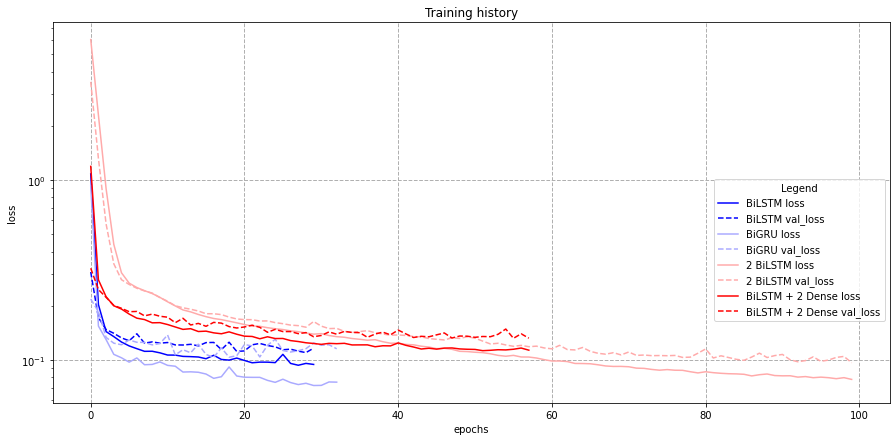

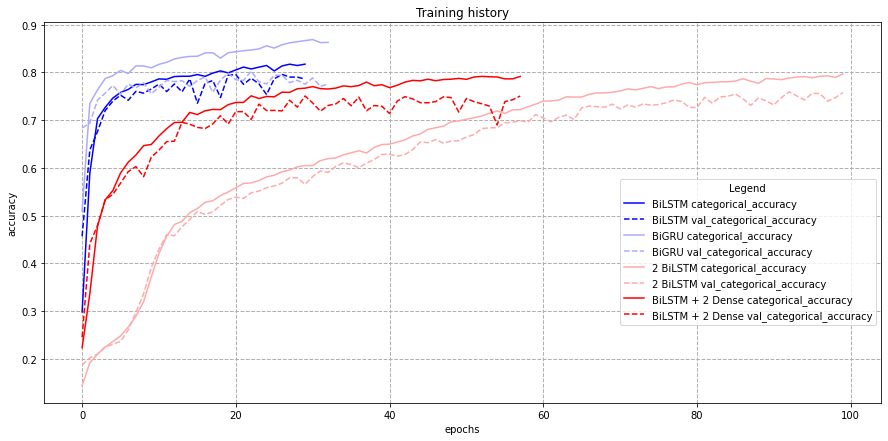

In [ ]:
models_history = [history_bilstm, history_bigru, history_two_bilstm, history_bilstm_two_dense]
model_names = ["BiLSTM", "BiGRU", "2 BiLSTM", "BiLSTM + 2 Dense"]
plot_history(models_history, keys=['loss', 'val_loss'], model_names=model_names, labels=("epochs", "loss"), y_scale="log", figsize=(15,7),  cmap='bwr')
plot_history(models_history, keys=['categorical_accuracy', 'val_categorical_accuracy'], model_names=model_names, labels=("epochs", "accuracy"), figsize=(15,7),  cmap='bwr')


### Training

History of the training: leonidas

## [Model Evaluation](https://github.com/LeonidasY/unibo-nlp-assignments/blob/main/Assignment%201/main.ipynb)


In [ ]:
def get_flattened_comparison(model, X_test, y_test):

    raw_y_pred = model.predict(X_test)

    # converting indexes to labels
    y_true_label = target_vectorizer.inverse_transform(y_test)
    y_pred_label = target_vectorizer.inverse_transform_probabilities(raw_y_pred)

    y_true_flat = []
    y_pred_flat = []
    for document_predicted, document_true in zip(y_pred_label, y_true_label):
        for word_predicted, word_true in zip (document_predicted, document_true):
            y_pred_flat.append(word_predicted)
            y_true_flat.append(word_true)
    return y_true_flat, y_pred_flat

1.   show_classification_report
2.   Voce elenco



## [Final Error analysis](https://github.com/BeleRicks11/Part-of-speech_Tagging/blob/main/Assignment_1_FINAL.ipynb)